In [1]:
#imports (same as assignment 3 of course: CS-C3240 Machine learning - 2024)
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import PolynomialFeatures   
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score    

#linear model imports
from sklearn.linear_model import LogisticRegression

import scipy.stats as stats

In [2]:
# read the data, create labels and separate feature candidates

#read data:
raw_df = pd.read_csv ('ObesityDataSet_raw_and_data_sinthetic.csv')
raw_df.head(5) #check it out

#exctract the candidates for features:
feature_candidates = raw_df[['CALC','FAVC','FCVC', 'NCP','SCC','SMOKE','CH2O','family_history_with_overweight','FAF','TUE','CAEC','MTRANS']]

#Create the labels:
height_and_weight = raw_df[['Height', 'Weight']]  #from these we can calculate the labels
labels = (height_and_weight['Weight'] / height_and_weight ['Height'].pow(2)) #this is series object
labels_df = pd.DataFrame(labels)
labels_df.rename(columns={0: "BMI_manual"}, inplace=True) #create BMI_label dataframe with a header

# code for checking out the dateframes:
#labels_df.head(5)
feature_candidates.head(5)

,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS
0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation
1,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation
3,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking
4,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [3]:
# Check which features have the best correlation with label

# First, do one-hot -encoding for the categorical features 
cat_features = raw_df[['CALC','FAVC','CAEC','family_history_with_overweight','MTRANS']]
cat_features_encoded = pd.get_dummies(cat_features, dtype = int)

# check also the numerical features in the data:
num_features = raw_df[['FCVC','NCP','CH2O','FAF','TUE']]

#combine encoded categorical features with numerical featrues in order to looka t the correlations:
combined_df = pd.concat([cat_features_encoded, num_features, labels_df], axis=1)
correlations_w_label = combined_df.corr()['BMI_manual'].drop('BMI_manual') #calculate correlations for each feature witht the label

#with this code we can check weather the feature are independent:
    #feature_correlations = pd.concat([cat_features_encoded, num_features],axis=1).corr()

#here are the print commands:
    #print(correlations_w_label)
    #print(feature_correlations)

    
#These are the features with the best correlation witht the label:
# CALC (How often do you drink alcohol?):
    # CALC_Always                          -0.019594
    # CALC_Frequently                      -0.062869
    # CALC_Sometimes                        0.235591
    # CALC_no                              -0.216842
    
# FAVC (Do you eat high caloric food frequently?):
    # FAVC_no                              -0.246097
    # FAVC_yes                              0.246097

# CAEC (Do you eat any food between meals?):
    # CAEC_Always                          -0.107704
    # CAEC_Frequently                      -0.395313
    # CAEC_Sometimes                        0.420548
    # CAEC_no                              -0.083957
    
# family_history_with_overweight            0.483508

# MTRANS (means of transpotation):
    # MTRANS_Automobile                    -0.033594
    # MTRANS_Bike                          -0.032631
    # MTRANS_Motorbike                     -0.035581
    # MTRANS_Public_Transportation          0.088204
    # MTRANS_Walking                       -0.124445

In [4]:
# Set up X and y for the classifier #

#exctract the selected features
features_raw = raw_df[['CALC','FAVC','CAEC','family_history_with_overweight','MTRANS']]
# one hot encoding for the features
features = pd.get_dummies(features_raw , dtype = int)

# cut the BMI based on the threshold 30
minvalue = labels.min() # minimum value of the BMI
maxvalue = labels.max() # maximum value of the BMI

bi_labels = [0,1] # new labels to be assigned, zero corresponding to not-obese
bi_cut_bins = [minvalue,30,maxvalue] #cutting intervals and criteria

# Encode BMI to binary labels
binarized_BMI = pd.cut(labels,\
                               bins=bi_cut_bins,labels=bi_labels,include_lowest=True)

# Create the feature matrix X
# and create label vector y binaried_BMI
X = features.to_numpy()
y = binarized_BMI.to_numpy()

#check out the type and shapes:
print(type(y))
print(y.shape)
print(X.shape)  #shapes are corresponding


<class 'numpy.ndarray'>
(2111,)
(2111, 17)


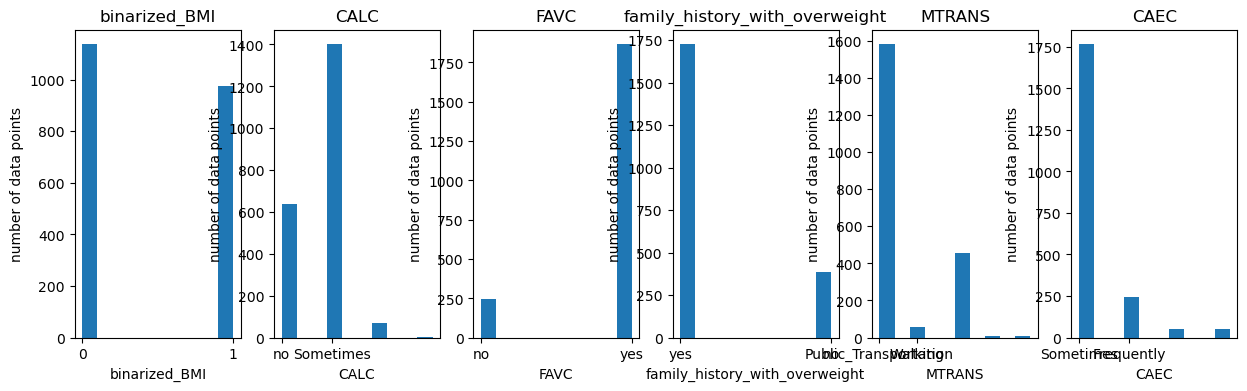

In [5]:
#Visualize the distribution of each column:

fig, axes = plt.subplots(1, 6, figsize=(15,4))

axes[0].hist(binarized_BMI)
axes[0].set_title('binarized_BMI')
axes[0].set_xlabel("binarized_BMI")
axes[0].set_ylabel('number of data points')
axes[0].set_xticks([0,1])

axes[1].hist(features_raw['CALC'])
axes[1].set_title('CALC')
axes[1].set_xlabel("CALC")
axes[1].set_ylabel('number of data points')
axes[1].set_xticks([0,1])

axes[2].hist(features_raw['FAVC'])
axes[2].set_title('FAVC')
axes[2].set_xlabel("FAVC")
axes[2].set_ylabel('number of data points')
axes[2].set_xticks([0,1])

axes[3].hist(features_raw['family_history_with_overweight'])
axes[3].set_title('family_history_with_overweight')
axes[3].set_xlabel("family_history_with_overweight")
axes[3].set_ylabel('number of data points')
axes[3].set_xticks([0,1])

axes[4].hist(features_raw['MTRANS']);
axes[4].set_title('MTRANS')
axes[4].set_xlabel("MTRANS")
axes[4].set_ylabel('number of data points')
axes[4].set_xticks([0,1])

axes[5].hist(features_raw['CAEC'])
axes[5].set_title('CAEC')
axes[5].set_xlabel("CAEC")
axes[5].set_ylabel('number of data points')
axes[5].set_xticks([0,1])

Text(0.5, 1.0, 'MTRANS vs BMI ')

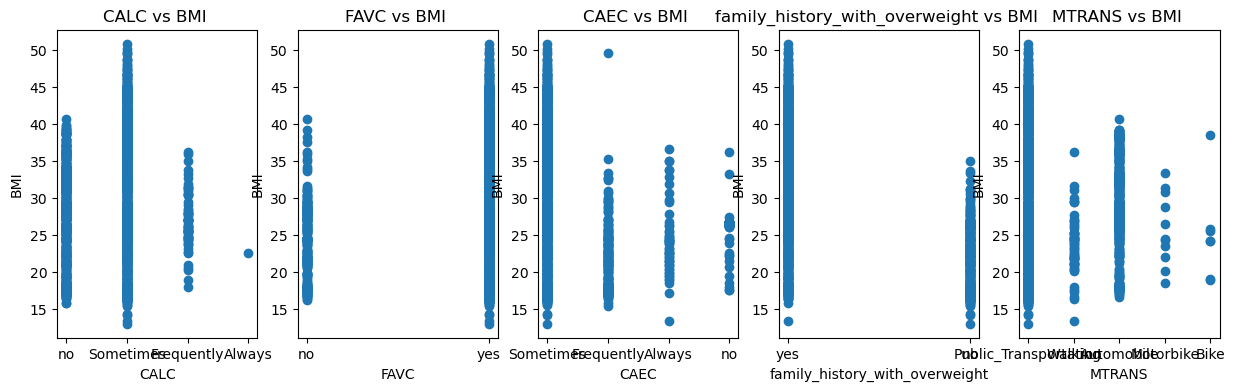

In [6]:
# Visualize feature label relationship

fig, axes = plt.subplots(1, 5, figsize=(15,4))
axes[0].scatter(features_raw['CALC'],labels);
axes[0].set_xlabel("CALC")
axes[0].set_ylabel("BMI")
axes[0].set_title("CALC vs BMI ")

axes[1].scatter(features_raw['FAVC'],labels);
axes[1].set_xlabel("FAVC")
axes[1].set_ylabel("BMI")
axes[1].set_title("FAVC vs BMI ")

axes[2].scatter(features_raw['CAEC'],labels);
axes[2].set_xlabel("CAEC")
axes[2].set_ylabel("BMI")
axes[2].set_title("CAEC vs BMI ")

axes[3].scatter(features_raw['family_history_with_overweight'],labels);
axes[3].set_xlabel("family_history_with_overweight")
axes[3].set_ylabel("BMI")
axes[3].set_title("family_history_with_overweight vs BMI ")

axes[4].scatter(features_raw['MTRANS'],labels);
axes[4].set_xlabel("MTRANS")
axes[4].set_ylabel("BMI")
axes[4].set_title("MTRANS vs BMI ")

In [8]:
#NOTE: the following model constructions are just for hyperparameter tuning
#The code constructing the final model metrics can be found at the end

#spilit the data to tran, validation and test sets:

#create validation set:
#X_train_init, X_val, y_train_init, y_val = train_test_split(X, y, test_size=0.2, random_state=8)
#create test set from train set:
#X_train, X_test, y_train, y_test = train_test_split(X_train_init, y_train_init, test_size=0.2, random_state=8)

In [9]:
#NOTE: the following model constructions are just for hyperparameter tuning
#The code constructing the final model metrics can be found at the end

#Create logistic regression model

clf_1 = LogisticRegression(fit_intercept= True ,  max_iter=1000)  
#different solver and max_iterations were tested, the model converges well with 100 iterations
clf_1.fit(X_train, y_train)

#training
y_pred_train = clf_1.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
conf_mat_train = confusion_matrix(y_train, y_pred_train)
recall_train_logr = conf_mat_train[1][1] / (conf_mat_train[1][1] + conf_mat_train[1][0])
precision_train_logr = conf_mat_train[1][1] / (conf_mat_train[1][1] + conf_mat_train[0][1])
F1_score_train_l = (2*precision_train_logr*recall_train_logr)/(precision_train_logr+recall_train_logr)

print("For the Logistic regression:\n")
print("training accuracy was : ", accuracy)
#print("training confusion matrix was: ","\n" ,conf_mat_train) #print the confusion matrix
print("training recall was:", recall_train_logr)
print("training F1 score was: ",F1_score_train_l)
      
#testing  
y_pred_test = clf_1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_mat_test = confusion_matrix(y_test, y_pred_test)
recall_test_logr = conf_mat_test[1][1] / (conf_mat_test[1][1] + conf_mat_test[1][0])
precision_test_logr = conf_mat_test[1][1] / (conf_mat_test[1][1] + conf_mat_test[0][1])
F1_score_test_l = (2*precision_test_logr*recall_test_logr)/(precision_test_logr+recall_test_logr)
print("and")
print("testing accuracy of LogReg: ",accuracy_test)
#print("testing confusion matrix:", "\n",conf_mat_test) #print the confusion matrix
print("testing recall was:", recall_test_logr)
print("testing F1 score was: ",F1_score_test_l)


For the Logistic regression:

training accuracy was :  0.7533333333333333
training recall was: 0.9425837320574163
training F1 score was:  0.7801980198019803
and
testing accuracy of LogReg:  0.7307692307692307
testing recall was: 0.9530201342281879
testing F1 score was:  0.7573333333333333


In [10]:
### Create decision tree classifier, test, train ###

#before continuting, edit the name of the validation set:
X_validation = X_val
y_validation = y_val

#create the model:
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 0) #min_samples_leaf = 2 
clf.fit(X_train, y_train)
y_pred_train_d = clf.predict(X_train)
y_pred_test_d = clf.predict(X_test)

Decision tree training metrix:
train Accuracy 0.7962962962962963
train recall 0.9250398724082934
train F1-score 0.782122905027933 

Decision tree testing metrix:
test Accuracy: 0.7692307692307693
test recall 0.9395973154362416
test F1-score 0.782122905027933


Text(50.722222222222214, 0.5, 'True labels')

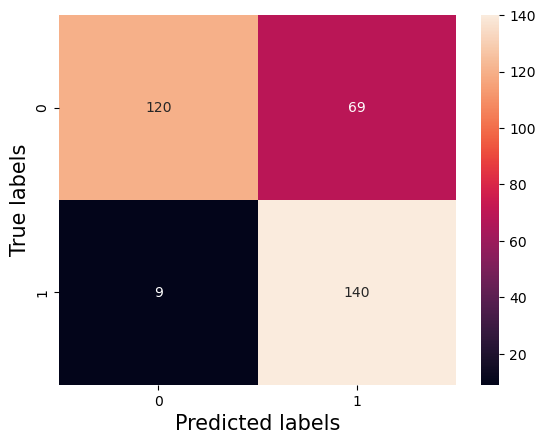

In [11]:
##scores##
acc_train = accuracy_score(y_train, y_pred_train_d)
confmat_train = confusion_matrix(y_train, y_pred_train_d)
recall_train = confmat_train[1][1] / (confmat_train[1][1] + confmat_train[1][0])
precision_train = confmat_train[1][1] / (confmat_train[1][1] + confmat_train[0][1])
F1_score_train = (2*precision_train*recall_train)/(precision_train+recall_train)

acc_test = accuracy_score(y_test, y_pred_test_d)
confmat_test = confusion_matrix(y_test, y_pred_test_d)
recall_test = confmat_test[1][1] / (confmat_test[1][1] + confmat_test[1][0])
precision_test = confmat_test[1][1] / (confmat_test[1][1] + confmat_test[0][1])
F1_score_test = (2*precision_test*recall_test)/(precision_test+recall_test)
 
print("Decision tree training metrix:")
print("train Accuracy", acc_train)
print("train recall", recall_train)
print("train F1-score", F1_score_test,"\n")

print("Decision tree testing metrix:")
print("test Accuracy:", acc_test)
print("test recall", recall_test)
print("test F1-score", F1_score_test)

# plot the confusion matrix of test
ax = plt.subplot()
sns.heatmap(confmat_test,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
#plt.show()


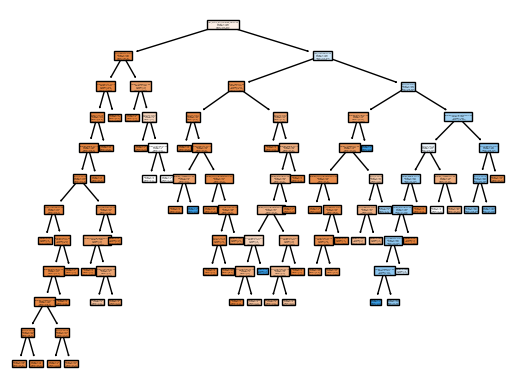

True

In [12]:
### plot tree ###
plot_tree(clf, feature_names = list(features.columns),  filled = True, class_names=["not obese", "obese"])
plt.show()

# save as pdf for a high res image:
import pydotplus
d_tree = export_graphviz(clf, feature_names = list(features.columns), filled = True, class_names=["not obese", "obese"])
pydot_graph = pydotplus.graph_from_dot_data(d_tree)
pydot_graph.write_pdf('obesity_tree.pdf')


In [16]:
#Validation of the models:

# ChatGPT was used to complete this code

# Create some estimate of the uncertainty of the metrics by looping over different random seeds.

#initialize the lists for different metrics (L for logistic regression and D for decision tree):
L_acc = []
L_rec = []
L_F1 = []

L_acc_train = []
L_rec_train = []
L_F1_train = []

D_acc = []
D_rec = []
D_F1 = []

D_acc_train = []
D_rec_train = []
D_F1_train = []


#separate the test set for later.
X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# Retrain the model with multiple different random seeds:
for seed in range(1, 100):
    # Create sets:
    X_train, X_val, y_train, y_val = train_test_split(X_train_init, y_train_init, test_size=0.2, random_state=seed)
    
    # Train the models:
    
    # Logistic Regression:
    clf_1 = LogisticRegression(fit_intercept=True, max_iter=1000)  
    clf_1.fit(X_train, y_train)
    y_pred_train_l = clf.predict(X_train)
    y_pred_val = clf_1.predict(X_val)
    
    # Decision tree:
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)  # min_samples_leaf = 2 
    clf.fit(X_train, y_train)
    y_pred_train_d = clf.predict(X_train)
    y_v_pred = clf.predict(X_val)  # Use X_val instead of creating a redundant variable
    
    # Calculate the metrics for Logistic Regression and append them to respective lists:
    accuracy_val = accuracy_score(y_val, y_pred_val)
    conf_mat_val = confusion_matrix(y_val, y_pred_val)
    recall_log_r = conf_mat_val[1][1] / (conf_mat_val[1][1] + conf_mat_val[1][0])
    precision_v_log_r = conf_mat_val[1][1] / (conf_mat_val[1][1] + conf_mat_val[0][1])
    F1_score_v_l = (2 * precision_v_log_r * recall_log_r) / (precision_v_log_r + recall_log_r)
    
    accuracy_train = accuracy_score(y_train, y_pred_train_l)
    conf_mat_train = confusion_matrix(y_train, y_pred_train_l)
    recall_train = conf_mat_val[1][1] / (conf_mat_val[1][1] + conf_mat_val[1][0])
    precision_train_log_r = conf_mat_val[1][1] / (conf_mat_val[1][1] + conf_mat_val[0][1])
    F1_score_train_l = (2 * precision_train_log_r * recall_train) / (precision_train_log_r + recall_train)
    

    L_acc.append(accuracy_val)
    L_rec.append(recall_log_r)
    L_F1.append(F1_score_v_l)
    
    L_acc_train.append(accuracy_train)
    L_rec_train.append(recall_train)
    L_F1_train.append(F1_score_train_l)
    
    
    # Calculate the metrics for Decision Tree and append them to respective lists:
    acc_v = accuracy_score(y_val, y_v_pred)
    confmat_v = confusion_matrix(y_val, y_v_pred)
    recall_v = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[1][0])
    precision_v = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[0][1])
    F1_score_v_d = (2 * precision_v * recall_v) / (precision_v + recall_v)

    acc_train = accuracy_score(y_train, y_pred_train_d)
    confmat_train = confusion_matrix(y_train, y_pred_train_d)
    recall_train_d = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[1][0])
    precision_train = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[0][1])
    F1_score_train = (2 * precision_train * recall_train_d) / (precision_train + recall_train_d)
    
    
    D_acc.append(acc_v)
    D_rec.append(recall_v)
    D_F1.append(F1_score_v_d)
    
    D_acc_train.append(acc_train)
    D_rec_train.append(recall_train_d)
    D_F1_train.append(F1_score_train)
    


In [17]:
#this code was produced by chatGPT

import numpy as np
import scipy.stats as stats

def compute_confidence_interval(metric_list):
    n = len(metric_list)
    mean = np.mean(metric_list)
    std_err = np.std(metric_list, ddof=1) / np.sqrt(n)
    z = stats.norm.ppf(0.975)  # 95% confidence interval
    lower_bound = mean - z * std_err
    upper_bound = mean + z * std_err
    return mean, (lower_bound, upper_bound)

# Calculate confidence intervals for Logistic Regression metrics
L_acc_mean, L_acc_CI = compute_confidence_interval(L_acc)
L_rec_mean, L_rec_CI = compute_confidence_interval(L_rec)
L_F1_mean, L_F1_CI = compute_confidence_interval(L_F1)

L_acc_mean_train, L_acc_CI_train = compute_confidence_interval(L_acc_train)
L_rec_mean_train, L_rec_CI_train = compute_confidence_interval(L_rec_train)
L_F1_mean_train, L_F1_CI_train = compute_confidence_interval(L_F1_train)


# Calculate confidence intervals for Decision Tree metrics
D_acc_mean, D_acc_CI = compute_confidence_interval(D_acc)
D_rec_mean, D_rec_CI = compute_confidence_interval(D_rec)
D_F1_mean, D_F1_CI = compute_confidence_interval(D_F1)

D_acc_mean_train, D_acc_CI_train = compute_confidence_interval(D_acc_train)
D_rec_mean_train, D_rec_CI_train = compute_confidence_interval(D_rec_train)
D_F1_mean_train, D_F1_CI_train = compute_confidence_interval(D_F1_train)


# Print the results
print(f"Logistic Regression training Accuracy: Mean = {L_acc_mean_train:.4f}, 95% CI = {L_acc_CI_train}")
print(f"Logistic Regression training Recall: Mean = {L_rec_mean_train:.4f}, 95% CI = {L_rec_CI_train}")
print(f"Logistic Regression training F1-Score: Mean = {L_F1_mean_train:.4f}, 95% CI = {L_F1_CI_train}")

print("\n",f"Logistic Regression Accuracy: Mean = {L_acc_mean:.4f}, 95% CI = {L_acc_CI}")
print(f"Logistic Regression Recall: Mean = {L_rec_mean:.4f}, 95% CI = {L_rec_CI}")
print(f"Logistic Regression F1-Score: Mean = {L_F1_mean:.4f}, 95% CI = {L_F1_CI}")


print("\n",f"Decision Tree training Accuracy: Mean = {D_acc_mean_train:.4f}, 95% CI = {D_acc_CI_train}")
print(f"Decision Tree training Recall: Mean = {D_rec_mean_train:.4f}, 95% CI = {D_rec_CI_train}")
print(f"Decision Tree training F1-Score: Mean = {D_F1_mean_train:.4f}, 95% CI = {D_F1_CI_train}")

print("\n",f"Decision Tree Accuracy: Mean = {D_acc_mean:.4f}, 95% CI = {D_acc_CI}")
print(f"Decision Tree Recall: Mean = {D_rec_mean:.4f}, 95% CI = {D_rec_CI}")
print(f"Decision Tree F1-Score: Mean = {D_F1_mean:.4f}, 95% CI = {D_F1_CI}")




Logistic Regression training Accuracy: Mean = 0.7838, 95% CI = (0.782772673282207, 0.7848143076381074)
Logistic Regression training Recall: Mean = 0.9324, 95% CI = (0.9272749843579303, 0.937589460004259)
Logistic Regression training F1-Score: Mean = 0.7764, 95% CI = (0.7723793577742599, 0.7803665757751383)

 Logistic Regression Accuracy: Mean = 0.7534, 95% CI = (0.7490771652328064, 0.7577664185338541)
Logistic Regression Recall: Mean = 0.9324, 95% CI = (0.9272749843579303, 0.937589460004259)
Logistic Regression F1-Score: Mean = 0.7764, 95% CI = (0.7723793577742599, 0.7803665757751383)

 Decision Tree training Accuracy: Mean = 0.7853, 95% CI = (0.7842987430430964, 0.7862960942184073)
Decision Tree training Recall: Mean = 0.9113, 95% CI = (0.907567179205302, 0.9150387690266216)
Decision Tree training F1-Score: Mean = 0.7903, 95% CI = (0.7863112027573318, 0.7943363539311432)

 Decision Tree Accuracy: Mean = 0.7781, 95% CI = (0.774127601739906, 0.7820854160115734)
Decision Tree Recall: Mea

In [18]:
# model test

clf = DecisionTreeClassifier(criterion="entropy", random_state=0)  # min_samples_leaf = 2 
clf.fit(X_test, y_test)
y_test_pred = clf.predict(X_test)

acc_test = accuracy_score(y_val, y_v_pred)
confmat_test = confusion_matrix(y_val, y_v_pred)
recall_test = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[1][0])
precision_test = confmat_v[1][1] / (confmat_v[1][1] + confmat_v[0][1])
F1_score_test = (2 * precision_test * recall_test) / (precision_test + recall_test)


print(f"Decisiton tree testing Accuracy: ",acc_test)
print(f"Decisiton tree testing Recall: ",recall_test)
print(f"Decisiton tree testing F1-Score: ",F1_score_test)



Decisiton tree testing Accuracy:  0.7869822485207101
Decisiton tree testing Recall:  0.9333333333333333
Decisiton tree testing F1-Score:  0.8105263157894737
